STEP ONE:Load the housepricecs data

In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse
from sqlalchemy import create_engine

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

import warnings
warnings.filterwarnings(action="ignore")

In [39]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [40]:
df.head(10)

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.000,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000
5,6,50,RL,85.000,14115,Pave,None,IR1,Lvl,AllPub,...,0,None,MnPrv,Shed,700,10,2009,WD,Normal,143000
6,7,20,RL,75.000,10084,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,8,2007,WD,Normal,307000
7,8,60,RL,nan,10382,Pave,None,IR1,Lvl,AllPub,...,0,None,None,Shed,350,11,2009,WD,Normal,200000
8,9,50,RM,51.000,6120,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,4,2008,WD,Abnorml,129900
9,10,190,RL,50.000,7420,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,1,2008,WD,Normal,118000


Do data cleaning, exploratory data analysis, and feature engineering. 

-use get dummies for string columns
-find correlation coefficient for sales price
-then from these highly correlated ones, eliminate columns that are highly correlated with each other

In [41]:
# select columns based on data type
object_type_columns = list(df.select_dtypes(include = 'object').columns) 
#print (object_type_columns)

#change object type to numerical type for the analysis
for column_name in object_type_columns:
    df[column_name] = pd.get_dummies(df[column_name], drop_first=True)

df.head() # to check

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,0,65.000,8450,1,0,0,0,0,...,0,0,0,0,0,2,2008,0,0,208500
1,2,20,0,80.000,9600,1,0,0,0,0,...,0,0,0,0,0,5,2007,0,0,181500
2,3,60,0,68.000,11250,1,0,0,0,0,...,0,0,0,0,0,9,2008,0,0,223500
3,4,70,0,60.000,9550,1,0,0,0,0,...,0,0,0,0,0,2,2006,0,0,140000
4,5,60,0,84.000,14260,1,0,0,0,0,...,0,0,0,0,0,12,2008,0,0,250000


In [42]:
df.columns

Index(['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paved

In [43]:
df[['overallqual','grlivarea']]

,overallqual,grlivarea
0,7,1710
1,6,1262
2,7,1786
3,7,1717
4,8,2198
5,5,1362
6,8,1694
7,7,2090
8,7,1774
9,5,1077


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null uint8
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null uint8
alley            1460 non-null uint8
lotshape         1460 non-null uint8
landcontour      1460 non-null uint8
utilities        1460 non-null uint8
lotconfig        1460 non-null uint8
landslope        1460 non-null uint8
neighborhood     1460 non-null uint8
condition1       1460 non-null uint8
condition2       1460 non-null uint8
bldgtype         1460 non-null uint8
housestyle       1460 non-null uint8
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null uint8
roofmatl         1460 non-null uint8
exterior1st      1460 non-null uint8
ext

from the output above, we see that some columns are missing values

In [45]:
df_columns = ['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition', 'saleprice']

for eachColumn in df_columns:
    df[eachColumn].fillna(df[eachColumn].median(), inplace = True) # replace empty spot with median
    
    
#df.columns.nunique() #check if worked

In [46]:
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null uint8
lotfrontage      1460 non-null float64
lotarea          1460 non-null int64
street           1460 non-null uint8
alley            1460 non-null uint8
lotshape         1460 non-null uint8
landcontour      1460 non-null uint8
utilities        1460 non-null uint8
lotconfig        1460 non-null uint8
landslope        1460 non-null uint8
neighborhood     1460 non-null uint8
condition1       1460 non-null uint8
condition2       1460 non-null uint8
bldgtype         1460 non-null uint8
housestyle       1460 non-null uint8
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null uint8
roofmatl         1460 non-null uint8
exterior1st      1460 non-null uint8
ext

Now from the output above, we see that there are no empty columns

In [47]:
from scipy.stats.mstats import winsorize
#df_winsorized = winsorize(df, (0, 0.10))

from sklearn.preprocessing import scale
#df_winsorized_scaled = scale(df_winsorized)
#df_winsorized
#df["winsorized_ HIV/AIDS "] = winsorized_views = winsorize(df[" HIV/AIDS"], (0, 0.10))

Find correlation coefficient of each column to 'saleprice'

In [48]:
corr = df.corr()
saleprice_corr = corr['saleprice']
high_pos_corr = saleprice_corr[saleprice_corr >= 0.5]
high_neg_corr = saleprice_corr[saleprice_corr <= -0.5] # nothing
print(high_pos_corr)
#print(high_neg_corr) # no variables are highly correlated to saleprice
#print('ok')

overallqual    0.791
yearbuilt      0.523
yearremodadd   0.507
totalbsmtsf    0.614
firstflrsf     0.606
grlivarea      0.709
fullbath       0.561
totrmsabvgrd   0.534
garagecars     0.640
garagearea     0.623
saleprice      1.000
Name: saleprice, dtype: float64


find correlation between these variables

In [49]:
#high_pos_corr_variables = ['overallqual','yearbuilt','yearremodadd','totalbsmtsf',
                           #'firstflrsf','grlivarea','fullbath','totrmsabvgrd','garagecars','garagearea']
high_pos_corr_df = corr[['overallqual','yearbuilt','yearremodadd','totalbsmtsf',
                'firstflrsf','grlivarea','fullbath','totrmsabvgrd','garagecars','garagearea','saleprice']]
#print(high_pos_corr_df)
high_pos_corr_df = high_pos_corr_df.loc[['overallqual','yearbuilt','yearremodadd','totalbsmtsf',
                    'firstflrsf','grlivarea','fullbath','totrmsabvgrd','garagecars','garagearea','saleprice']
                    ]
print (high_pos_corr_df)

              overallqual  yearbuilt  yearremodadd  totalbsmtsf  firstflrsf  \
overallqual         1.000      0.572         0.551        0.538       0.476   
yearbuilt           0.572      1.000         0.593        0.391       0.282   
yearremodadd        0.551      0.593         1.000        0.291       0.240   
totalbsmtsf         0.538      0.391         0.291        1.000       0.820   
firstflrsf          0.476      0.282         0.240        0.820       1.000   
grlivarea           0.593      0.199         0.287        0.455       0.566   
fullbath            0.551      0.468         0.439        0.324       0.381   
totrmsabvgrd        0.427      0.096         0.192        0.286       0.410   
garagecars          0.601      0.538         0.421        0.435       0.439   
garagearea          0.562      0.479         0.372        0.487       0.490   
saleprice           0.791      0.523         0.507        0.614       0.606   

              grlivarea  fullbath  totrmsabvgrd  ga

I wanna highlight values in the dataframe above that are highly correlated with each other

In [50]:
def high_corr(val):
    #"""
    #Takes a scalar and returns a string with
    #the css property `'color: red'` for negative
    #strings, black otherwise.
    #"""
    color = 'red' if val >= 0.5 else 'black'
    return 'color: %s' % color

In [51]:
s = high_pos_corr_df.style.applymap(high_corr)
s

,overallqual,yearbuilt,yearremodadd,totalbsmtsf,firstflrsf,grlivarea,fullbath,totrmsabvgrd,garagecars,garagearea,saleprice
overallqual,1,0.572323,0.550684,0.537808,0.476224,0.593007,0.5506,0.427452,0.600671,0.562022,0.790982
yearbuilt,0.572323,1,0.592855,0.391452,0.281986,0.19901,0.468271,0.0955891,0.53785,0.478954,0.522897
yearremodadd,0.550684,0.592855,1,0.291066,0.240379,0.287389,0.439046,0.19174,0.420622,0.3716,0.507101
totalbsmtsf,0.537808,0.391452,0.291066,1,0.81953,0.454868,0.323722,0.285573,0.434585,0.486665,0.613581
firstflrsf,0.476224,0.281986,0.240379,0.81953,1,0.566024,0.380637,0.409516,0.439317,0.489782,0.605852
grlivarea,0.593007,0.19901,0.287389,0.454868,0.566024,1,0.630012,0.825489,0.467247,0.468997,0.708624
fullbath,0.5506,0.468271,0.439046,0.323722,0.380637,0.630012,1,0.554784,0.469672,0.405656,0.560664
totrmsabvgrd,0.427452,0.0955891,0.19174,0.285573,0.409516,0.825489,0.554784,1,0.362289,0.337822,0.533723
garagecars,0.600671,0.53785,0.420622,0.434585,0.439317,0.467247,0.469672,0.362289,1,0.882475,0.640409
garagearea,0.562022,0.478954,0.3716,0.486665,0.489782,0.468997,0.405656,0.337822,0.882475,1,0.623431


I'm going to graph overallqual,totalbsmtsf,grlivarea,garagecars	

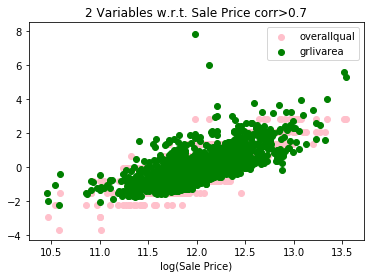

In [52]:
#PLOT CORR COEFF > 0.7

y_1=scale(winsorize(df['overallqual']))
#y_2=df['totalbsmtsf']
y_3=scale(winsorize(df['grlivarea']))
#y_4=df['garagecars']


plt.scatter(x=np.log(df['saleprice']), y=y_1, color='pink', label = 'overallqual')
#plt.scatter(x=np.log(df['saleprice']), y=y_2, color='yellow', label = 'totalbsmtsf') 
plt.scatter(x=np.log(df['saleprice']), y=y_3, color='green', label = 'grlivarea')
#plt.scatter(x=np.log(df['saleprice']), y=y_4, color='lightblue', label = 'garagecars') 

plt.xlabel('log(Sale Price)')
plt.legend()
plt.title('2 Variables w.r.t. Sale Price corr>0.7')

plt.show()

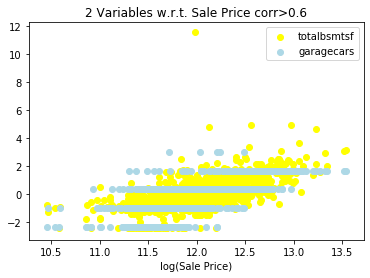

In [53]:
#CORR COEFF >0.6
y_2=scale(winsorize(df['totalbsmtsf']))
y_4=scale(winsorize(df['garagecars']))

plt.scatter(x=np.log(df['saleprice']), y=y_2, color='yellow', label = 'totalbsmtsf') 
plt.scatter(x=np.log(df['saleprice']), y=y_4, color='lightblue', label = 'garagecars')

plt.xlabel('log(Sale Price)')
plt.legend()
plt.title('2 Variables w.r.t. Sale Price corr>0.6')

plt.show()

Now, split your data into train and test sets where 20% of the data resides in the test set.

In [54]:
# Y is the target variable
Y = df['saleprice']

X = df[['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition']]


X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

Build several linear regression models including LASSO, RIDGE, or ELASTICNET and train them in the training set. Use k-fold cross-validation to select the best hyperparameters if your models include one!

OLS

In [55]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X_train_1 = sm.add_constant(X_train)

results = sm.OLS(y_train, X_train_1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     74.84
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        15:38:17   Log-Likelihood:                -13759.
No. Observations:                1168   AIC:                         2.767e+04
Df Residuals:                    1091   BIC:                         2.806e+04
Df Model:                          76                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -5.06e+05   1.53e+06     -0.332      0.740    -3.5e+06    2.49e+06
id               -2.3336      2.346     -0.994      0.320      -6.938       2.271
mssubclass     -212.6061     34.167     -6.223      0.000    -279.646    -145.566
mszoning       8250.6655   5741.901      1.437      0.151   -3015.752    1.95e+04
lotfrontage     -58.8468     57.045     -1.032      0.302    -170.777      53.084
lotarea           0.2292      0.111      2.057      0.040       0.011       0.448
street         2.095e+04   1.66e+04      1.266      0.206   -1.15e+04    5.34e+04
alley         -6659.1793   6907.493     -0.964      0.335   -2.02e+04    6894.295
lotshape       8207.8871   5860.354      1.401      0.162   -3290.952    1.97e+04
landcontour    8621.2424   5524.275      1.561      0.119   -2218.163    1.95e+04
utilities     -6.768e+04   3.41e+04     -1.984      0.047   -1.35e+05    -762.004
lotconfig      9911.3102   4187.579      2.367      0.018    1694.691    1.81e+04
landslope      4101.2035   5235.437      0.783      0.434   -6171.461    1.44e+04
neighborhood  -7675.5476   2.37e+04     -0.324      0.746   -5.41e+04    3.88e+04
condition1    -1.234e+04   4438.823     -2.780      0.006    -2.1e+04   -3629.029
condition2     -1.01e+04   1.42e+04     -0.711      0.477    -3.8e+04    1.78e+04
bldgtype       2.717e+04   9031.984      3.008      0.003    9446.402    4.49e+04
housestyle     2361.2261   9968.559      0.237      0.813   -1.72e+04    2.19e+04
overallqual    1.649e+04   1382.893     11.927      0.000    1.38e+04    1.92e+04
overallcond    5998.7341   1189.660      5.042      0.000    3664.454    8333.014
yearbuilt       432.3521     79.717      5.424      0.000     275.937     588.768
yearremodadd    107.7511     74.816      1.440      0.150     -39.048     254.551
roofstyle     -4983.2749   2627.935     -1.896      0.058   -1.01e+04     173.103
roofmatl        2.17e+04   8212.039      2.642      0.008    5585.882    3.78e+04
exterior1st   -5.375e-09   3.31e-09     -1.626      0.104   -1.19e-08    1.11e-09
exterior2nd    6631.8723   2.39e+04      0.277      0.782   -4.03e+04    5.35e+04
masvnrtype    -1.115e+04   2736.966     -4.073      0.000   -1.65e+04   -5777.696
masvnrarea       56.4213      7.633      7.392      0.000      41.445      71.397
exterqual       1.14e+04   1.28e+04      0.892      0.372   -1.37e+04    3.65e+04
extercond     -1430.7174   8318.740     -0.172      0.863   -1.78e+04    1.49e+04
foundation    -4348.2627   2663.800     -1.632      0.103   -9575.012     878.487
bsmtqual      -2147.6921   6711.902     -0.320      0.749   -1.53e+04     1.1e+04
bsmtcond       -401.4286   5084.123     -0.079      0.937   -1.04e+04    9574.337
bsmtexposure   1.967e+04   4076.087      4.825      0.000    1.17e+04    2.77e+04
bsmtfintype1   2957.3666   3446.405      0.858   

In [32]:
# We fit an OLS model using sklearn 
# wanted to use sklearn here to validate R-squared above
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train_OLS = lrm.predict(X_train)
y_preds_test_OLS = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_OLS)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_OLS)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_OLS)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_OLS) / y_test)) * 100))

R-squared of the model in the training set is: 0.839057149380982
-----Test set statistics-----
R-squared of the model in the test set is: 0.7025896473321621
Mean absolute error of the prediction is: 23677.81283017656
Mean squared error of the prediction is: 1996725097.8647265
Root mean squared error of the prediction is: 44684.730030120205
Mean absolute percentage error of the prediction is: 13.495255992817151


LASSO (diff = 0.137)

In [28]:
from sklearn.linear_model import Lasso

lassoregr = Lasso(alpha=0.01) 
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train_lasso = lassoregr.predict(X_train)
y_preds_test_lasso = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_lasso)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_lasso)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_lasso)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_lasso) / y_test)) * 100))

R-squared of the model on the training set is: 0.8390571492654951
-----Test set statistics-----
R-squared of the model on the test set is: 0.7025899222730256
Mean absolute error of the prediction is: 23677.725634916533
Mean squared error of the prediction is: 1996723251.9931302
Root mean squared error of the prediction is: 44684.709375726394
Mean absolute percentage error of the prediction is: 13.495198446056591


ElasicNet (diff = 0.136)

In [29]:
from sklearn.linear_model import ElasticNet

elasticregr = ElasticNet(alpha=0.01, l1_ratio=0.5) 
elasticregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train_elasticnet = elasticregr.predict(X_train)
y_preds_test_elasticnet = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_elasticnet)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_elasticnet)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_elasticnet)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_elasticnet) / y_test)) * 100))


R-squared of the model on the training set is: 0.8379162652881628
-----Test set statistics-----
R-squared of the model on the test set is: 0.7016086351686862
Mean absolute error of the prediction is: 23422.473739360776
Mean squared error of the prediction is: 2003311323.2282748
Root mean squared error of the prediction is: 44758.3659579779
Mean absolute percentage error of the prediction is: 13.307445128301415


In [33]:
Ridge (diff = 0.137)

TypeError: __init__() got an unexpected keyword argument 'diff'

In [30]:
from sklearn.linear_model import Ridge

# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = Ridge(alpha=0.01) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train_ridge = ridgeregr.predict(X_train)
y_preds_test_ridge = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test_ridge)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test_ridge)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test_ridge)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test_ridge) / y_test)) * 100))


R-squared of the model on the training set is: 0.8390570704748807
-----Test set statistics-----
R-squared of the model on the test set is: 0.7025951507419435
Mean absolute error of the prediction is: 23676.876062031355
Mean squared error of the prediction is: 1996688149.6000295
Root mean squared error of the prediction is: 44684.316595423385
Mean absolute percentage error of the prediction is: 13.494702030014741


All the models seem to be similar since they all seem to be fairly accurate.

In [34]:
#These are the unique years
df['yrsold'].unique()

array([2008, 2007, 2006, 2009, 2010])

Source
https://www.valuepenguin.com/mortgages/historical-mortgage-rates
year // avg interest rate
2008 // 6.03
2007 // 6.34
2006 // 6.41
2009 // 5.04
2010 // 4.69

Then I need to add these values according to the years in the row

In [101]:
#added empty column to df
df['avgintrate (%)'] = 0
del df['avgintrate']

In [102]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,avgintrate (%)
0,1,60,0,65.000,8450,1,0,0,0,0,...,0,0,0,0,2,2008,0,0,208500,0
1,2,20,0,80.000,9600,1,0,0,0,0,...,0,0,0,0,5,2007,0,0,181500,0
2,3,60,0,68.000,11250,1,0,0,0,0,...,0,0,0,0,9,2008,0,0,223500,0
3,4,70,0,60.000,9550,1,0,0,0,0,...,0,0,0,0,2,2006,0,0,140000,0
4,5,60,0,84.000,14260,1,0,0,0,0,...,0,0,0,0,12,2008,0,0,250000,0


In [103]:
#Source: https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
df.loc[(df.yrsold == 2008),'avgintrate (%)'] = 6.03
df.loc[(df.yrsold == 2007),'avgintrate (%)'] = 6.34
df.loc[(df.yrsold == 2006),'avgintrate (%)'] = 6.41
df.loc[(df.yrsold == 2009),'avgintrate (%)'] = 5.04
df.loc[(df.yrsold == 2010),'avgintrate (%)'] = 4.69

In [104]:
df.head()

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice,avgintrate (%)
0,1,60,0,65.000,8450,1,0,0,0,0,...,0,0,0,0,2,2008,0,0,208500,6.030
1,2,20,0,80.000,9600,1,0,0,0,0,...,0,0,0,0,5,2007,0,0,181500,6.340
2,3,60,0,68.000,11250,1,0,0,0,0,...,0,0,0,0,9,2008,0,0,223500,6.030
3,4,70,0,60.000,9550,1,0,0,0,0,...,0,0,0,0,2,2006,0,0,140000,6.410
4,5,60,0,84.000,14260,1,0,0,0,0,...,0,0,0,0,12,2008,0,0,250000,6.030


In [105]:
# Y is the target variable
Y = df['saleprice']

X_avgintrate = df[['id', 'mssubclass', 'mszoning', 'lotfrontage', 'lotarea', 'street',
       'alley', 'lotshape', 'landcontour', 'utilities', 'lotconfig',
       'landslope', 'neighborhood', 'condition1', 'condition2', 'bldgtype',
       'housestyle', 'overallqual', 'overallcond', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'masvnrarea', 'exterqual', 'extercond', 'foundation', 'bsmtqual',
       'bsmtcond', 'bsmtexposure', 'bsmtfintype1', 'bsmtfinsf1',
       'bsmtfintype2', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf', 'heating',
       'heatingqc', 'centralair', 'electrical', 'firstflrsf', 'secondflrsf',
       'lowqualfinsf', 'grlivarea', 'bsmtfullbath', 'bsmthalfbath', 'fullbath',
       'halfbath', 'bedroomabvgr', 'kitchenabvgr', 'kitchenqual',
       'totrmsabvgrd', 'functional', 'fireplaces', 'fireplacequ', 'garagetype',
       'garageyrblt', 'garagefinish', 'garagecars', 'garagearea', 'garagequal',
       'garagecond', 'paveddrive', 'wooddecksf', 'openporchsf',
       'enclosedporch', 'threessnporch', 'screenporch', 'poolarea', 'poolqc',
       'fence', 'miscfeature', 'miscval', 'mosold', 'yrsold', 'saletype',
       'salecondition','avgintrate (%)']]


X_avgintrate_train, X_avgintrate_test, y_train, y_test = train_test_split(X_avgintrate, Y, test_size = 0.2, random_state = 465)

In [106]:
import statsmodels.api as sm

# We need to manually add a constant
# in statsmodels' sm
X_avgintrate_train_1 = sm.add_constant(X_avgintrate_train)

results = sm.OLS(y_train, X_avgintrate_train_1).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              saleprice   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.828
Method:                 Least Squares   F-statistic:                     73.85
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        16:51:56   Log-Likelihood:                -13758.
No. Observations:                1168   AIC:                         2.767e+04
Df Residuals:                    1090   BIC:                         2.807e+04
Df Model:                          77                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           2.677e+06   4.48e+06      0.597      0.550   -6.12e+06    1.15e+07
id                -2.3757      2.348     -1.012      0.312      -6.982       2.231
mssubclass      -212.5077     34.174     -6.218      0.000    -279.562    -145.454
mszoning        8217.1679   5743.202      1.431      0.153   -3051.814    1.95e+04
lotfrontage      -59.7342     57.068     -1.047      0.295    -171.711      52.242
lotarea            0.2317      0.112      2.078      0.038       0.013       0.450
street          2.035e+04   1.66e+04      1.228      0.220   -1.22e+04    5.29e+04
alley          -6441.4326   6914.861     -0.932      0.352      -2e+04    7126.512
lotshape        8060.9662   5864.732      1.374      0.170   -3446.474    1.96e+04
landcontour     8751.1318   5528.036      1.583      0.114   -2095.664    1.96e+04
utilities       -6.84e+04   3.41e+04     -2.004      0.045   -1.35e+05   -1435.928
lotconfig       9772.6348   4192.423      2.331      0.020    1546.503     1.8e+04
landslope       4171.1121   5237.285      0.796      0.426   -6105.188    1.44e+04
neighborhood   -7386.1320   2.37e+04     -0.312      0.755   -5.38e+04    3.91e+04
condition1     -1.219e+04   4444.192     -2.742      0.006   -2.09e+04   -3467.493
condition2     -1.001e+04   1.42e+04     -0.704      0.481   -3.79e+04    1.79e+04
bldgtype         2.72e+04   9033.869      3.011      0.003    9476.053    4.49e+04
housestyle      2623.7998   9976.575      0.263      0.793    -1.7e+04    2.22e+04
overallqual      1.65e+04   1383.167     11.926      0.000    1.38e+04    1.92e+04
overallcond     6076.6591   1194.356      5.088      0.000    3733.163    8420.156
yearbuilt        431.3134     79.744      5.409      0.000     274.844     587.783
yearremodadd     108.1933     74.833      1.446      0.149     -38.640     255.026
roofstyle      -4969.1986   2628.518     -1.890      0.059   -1.01e+04     188.329
roofmatl         2.15e+04   8217.910      2.616      0.009    5374.556    3.76e+04
exterior1st     9.821e-10   1.09e-09      0.897      0.370   -1.17e-09    3.13e-09
exterior2nd     6963.1852   2.39e+04      0.291      0.771      -4e+04    5.39e+04
masvnrtype     -1.114e+04   2737.518     -4.070      0.000   -1.65e+04   -5769.996
masvnrarea        56.6785      7.642      7.417      0.000      41.685      71.672
exterqual       1.114e+04   1.28e+04      0.871      0.384   -1.39e+04    3.62e+04
extercond      -1529.7083   8321.408     -0.184      0.854   -1.79e+04    1.48e+04
foundation     -4411.4904   2665.638     -1.655      0.098   -9641.852     818.871
bsmtqual       -2448.5698   6725.024     -0.364      0.716   -1.56e+04    1.07e+04
bsmtcond        -608.8195   5092.527     -0.120      0.905   -1.06e+04    9383.445
bsmtexposure    1.979e+04   4080.029      4.850      0.000    1.18e+04    2.78e+04
bsmtfintype1

Adding 'avgintrate' to my dataframe doesn't seem to have changed since the R-squared values is the same for when I added this information to when I didn't add it.

In [111]:
# training a KNN classifier 
from sklearn.neighbors import KNeighborsClassifier 
knn = KNeighborsClassifier(n_neighbors = 7).fit(X_avgintrate_train_1, y_train)
accuracy = knn.predict(X_avgintrate_test) 
print (accuracy)

ValueError: query data dimension must match training data dimension